In [1]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/CW30154-hnrnpk")
results_dir.mkdir(parents=True, exist_ok=True)

 Load input RNA allelic counts.

In [2]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = [ basedir + "CW30154-hnrnpk-input_allelic.out" ]

IP_files = [ basedir + "CW30154-hnrnpk-ip_allelic.out" ]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,10,0,10
1,chr1,16141,rs529651976,C,T,14,0,14
2,chr1,16280,.,T,C,20,0,20
3,chr1,137978,rs529853750,G,A,62,0,62
4,chr1,139029,rs531551691,C,T,85,0,85


Observed genotype data (after running StrandScript)

## Load imputed genotypes

In [3]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [4]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

# Load IP count data and join with input and genotype

<AxesSubplot:>

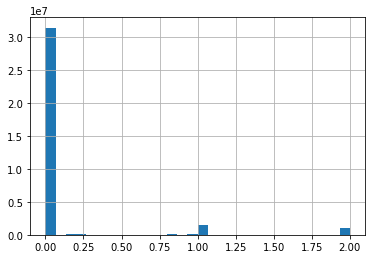

In [20]:
sample_ind = [ g for g in cols if "CW30154" in g ][0]
sanger[sample_ind].hist(bins=30)

In [17]:
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]
IP_counts[0]

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,80,0,80
1,chr1,16141,rs529651976,C,T,82,0,82
2,chr1,16280,.,T,C,63,0,63
3,chr1,137978,rs529853750,G,A,252,0,252
4,chr1,139029,rs531551691,C,T,299,0,299
...,...,...,...,...,...,...,...,...
1790782,chr22,50777260,rs551225150,C,T,18,0,18
1790783,chr22,50777292,.,A,G,14,0,14
1790784,chr22,50777325,rs549110447,T,C,12,0,12
1790785,chr22,50777331,rs567609012,C,G,12,0,12


In [18]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[47.223344]

In [19]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[47.338812]

Joining genotype and input allelic counts


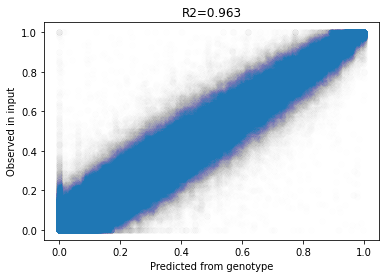

Joining genotype+input with IP allelic counts


In [17]:
merged = {} 
dat_sub = {}
for rep_index in range(len(input_counts)):
    merged[rep_index],dat_sub[rep_index] = deconvolve.merge_geno_and_counts(sanger, 
                                                                            input_counts[rep_index], 
                                                                            IP_counts[rep_index], 
                                                                            w[rep_index], 
                                                                            plot = True)

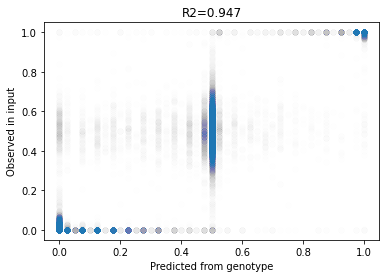

Joining genotype+input with IP allelic counts


In [23]:
if False: 
    dat = input_counts[0]
    dat_IP = IP_counts[0]

    dat = dat[dat.variantID != "."]
    dat = dat[~dat.variantID.duplicated()]
    dat_IP = dat_IP[dat_IP.variantID != "."]
    dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

    # have to match on rsID because sanger.vcf is hg19 and allelic counts are on hg38
    print("Joining genotype and input allelic counts")
    imp_merged = sanger.rename(columns = {"SNP" : "variantID"}
                              ).merge(dat, 
                                      on = ["contig", "variantID", "refAllele", "altAllele"],
                                     suffixes = ["_hg19",""]) # sanger is hg19
    # there are only 0.08% flipped alleles so not worth doing.
    # np.isnan(imp_merged.iloc[:,5:16]).any() all False
    imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount

imp_merged["pred_ratio"] = 0.5 * imp_merged.loc[:,sample_ind].to_numpy()

imp_merged_30 = imp_merged[imp_merged.totalCount >= 30]
corr,_ = scipy.stats.pearsonr(imp_merged_30.pred_ratio, imp_merged_30.input_ratio)
R2 = corr*corr
plt.scatter(imp_merged_30.pred_ratio, imp_merged_30.input_ratio, alpha = 0.005) 
plt.title("R2=%.3f" % R2)
plt.xlabel("Predicted from genotype")
plt.ylabel("Observed in input")
plt.axvline(x = 0.45, color = 'r')
plt.axvline(x = 0.55, color = 'r')
plt.show()

# merge (imp_geno+input) with IP
print("Joining genotype+input with IP allelic counts")
merged = imp_merged.drop(labels=sanger.columns[range(5,16)], axis=1 # # .rename(columns={"position_y":"position"} # ,"contig_x":"contig" ?
                        ).merge(dat_IP, 
                                on = ("contig", "position", "variantID", "refAllele", "altAllele"), 
                                suffixes = ("_input", "_IP"))
#merged = merged.drop(labels=["contig_y", "position_x" ], axis=1)

merged["IP_ratio"] = merged.altCount_IP / merged.totalCount_IP

input_total_min = 10
allele_count_min = 4 
ip_total_min = 30

dat_sub = merged[merged.totalCount_input >= input_total_min]
dat_sub = dat_sub[dat_sub.refCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.altCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.totalCount_IP >= ip_total_min]
dat_sub = dat_sub[dat_sub.pred_ratio >= 0.45]
dat_sub = dat_sub[dat_sub.pred_ratio <= 0.55]

In [40]:
dat_subsub = dat_sub[dat_sub.pred_ratio == 0.5]

<AxesSubplot:>

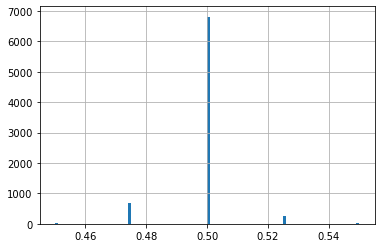

In [39]:
dat_sub.pred_ratio.hist(bins=100)

# Run beta models

Learned hyperparameters: {'input_conc': 65.43270111083984, 'input_count_conc': 127.34178161621094, 'IP_conc': 49.89799118041992, 'IP_count_conc': 212.3877716064453}


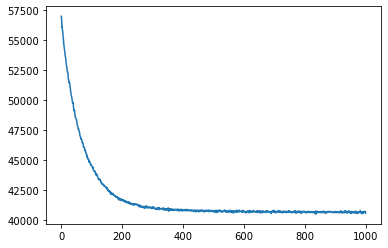

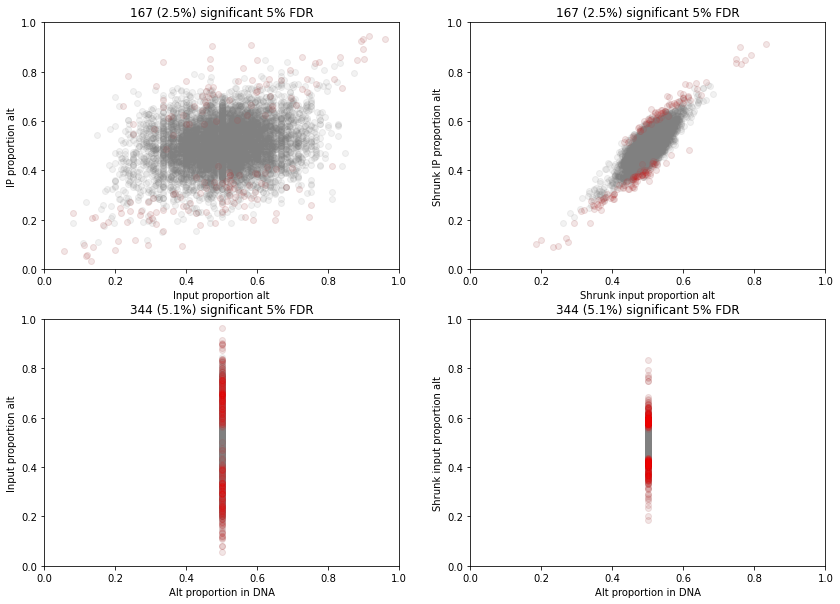

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,input_ratio,...,totalCount_IP,IP_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q
0,chr10,956400,rs7069505,C,T,910460,8,15,23,0.652174,...,49,0.571429,0.231224,0.231224,0.171103,0.088287,0.225528,-0.005697,0.222028,0.489765
1,chr10,970426,rs11253516,A,G,924486,22,20,42,0.476190,...,40,0.575000,0.011196,0.011196,0.157642,0.471690,0.128471,0.117275,0.216013,0.293597
2,chr10,1058196,rs17131848,C,T,1012256,7,5,12,0.416667,...,33,0.575758,0.092355,0.092355,0.207929,0.328462,0.091469,-0.000886,0.249267,0.498582
3,chr10,5490932,rs12570751,A,T,5448969,5,6,11,0.545455,...,38,0.421053,-0.041453,-0.041453,0.195225,0.415923,-0.081995,-0.040542,0.189202,0.415164
4,chr10,5491495,rs56676146,A,G,5449532,9,5,14,0.357143,...,62,0.467742,-0.159593,-0.159593,0.189450,0.199781,-0.143951,0.015642,0.235675,0.473540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,chr9,140481946,rs2297005,G,A,137587494,8,11,19,0.578947,...,69,0.463768,0.082906,0.082906,0.200758,0.339817,-0.066163,-0.149068,0.211744,0.240715
6802,chr9,140483339,rs2297004,G,A,137588887,5,7,12,0.583333,...,70,0.428571,-0.062381,-0.062381,0.176493,0.361876,-0.168157,-0.105775,0.213610,0.310237
6803,chr9,140512555,rs1045777,G,A,137618103,15,18,33,0.545455,...,41,0.536585,0.096870,0.096870,0.182586,0.297866,0.108962,0.012092,0.231030,0.479130
6804,chr9,140530935,rs2501566,A,G,137636483,16,14,30,0.466667,...,31,0.677419,0.062388,0.062388,0.195233,0.374652,0.225764,0.163376,0.178729,0.180332


In [45]:

results = beta_model.fit_and_save(dat_subsub, 
                                 results_dir / ("beta" 
                                                + ("_struct" if use_structured_guide else "") 
                                                + ".tsv.gz"),
                                 use_structured_guide = True,
                                 iterations = 1000,
                                 device = device)
results

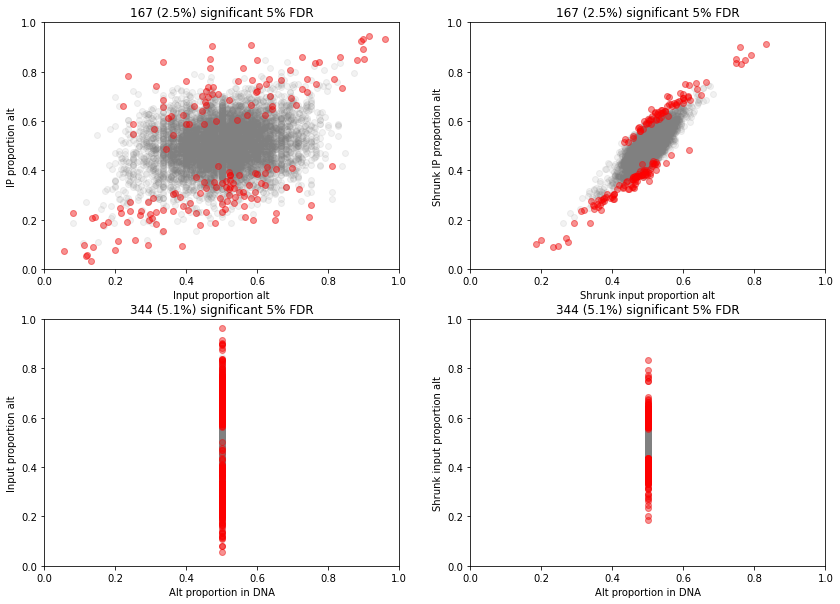

()

In [47]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

# Gaussian model without replicates

Could also run this with the mean field guide. 

Learned hyperparameters: {'ase_scale': 0.1695626825094223, 'input_count_conc': 139.3909454345703, 'asb_scale': 0.1954687535762787, 'IP_count_conc': 110.2754135131836, 'ase_t_df': 4.1406402587890625, 'asb_t_df': 7.984660625457764}


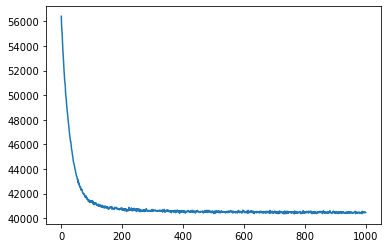

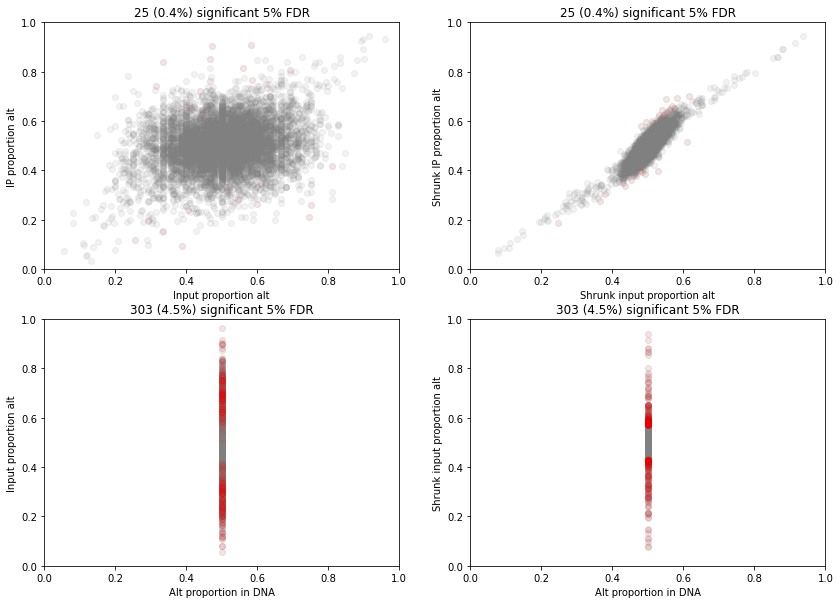

In [48]:
results = gaussian_model.fit_and_save(dat_subsub, 
                                         results_dir / ("normal" 
                                                        + ("_struct" if use_structured_guide else "") 
                                                        + ".tsv.gz"),
                                         use_structured_guide = True,
                                         iterations = 1000,
                                         device = "cuda:0")

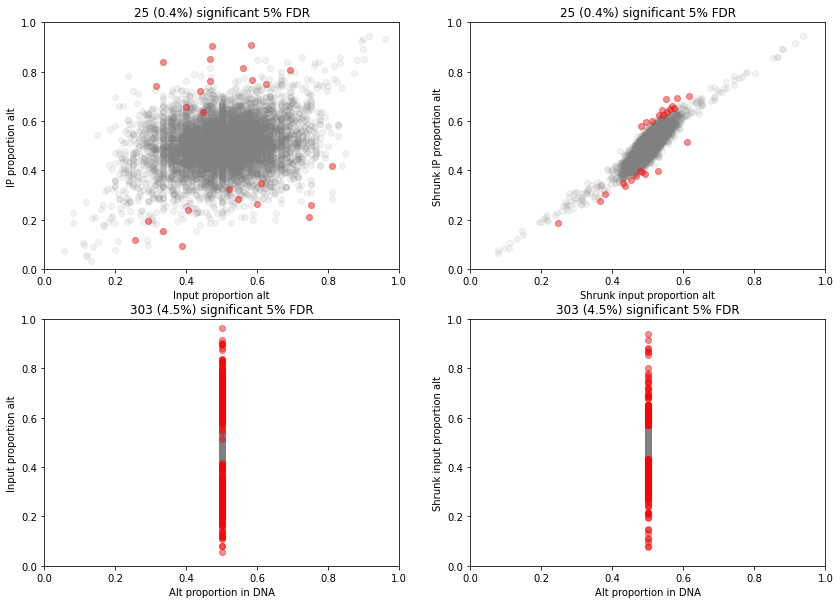

()

In [49]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)